# Data Preprocessing

# Amazon Fine Food Reviews


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).


In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")



import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

###  Loading the data which we have saved after Data cleaning

In [2]:
conn = sqlite3.connect('final.sqlite')
final_data = pd.read_sql_query(""" SELECT * FROM Reviews """, conn) 
conn.close

<function Connection.close>

In [3]:
final_data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc..."
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...


<h4>We have two text features in our dataset (Summary and Text). These Text features needs to be preprocessed</h4>

## Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

### Text Preprocessing

#### [1] HTML Tag Removal

In [4]:
#Function to clean html tags from a sentence
import re
def removeHtml(sentence): 
    pattern = re.compile('<.*?>')
    cleaned_text = re.sub(pattern,' ',sentence)
    return cleaned_text

removeHtml('<a href="foo.com" class="bar">I Want This <b>text!</b></a><>')

' I Want This  text!   '

#### [2] Punctuations Removal

In [5]:
#Function to keep only words containing letters A-Z and a-z. This will remove all punctuations, special characters etc. https://stackoverflow.com/a/5843547/4084039
def removePunctuations(sentence):
    cleaned_text  = re.sub('[^a-zA-Z]',' ',sentence)
    return (cleaned_text)

removePunctuations("fsd*?~,,,( sdfsdfdsvv)#")

'fsd        sdfsdfdsvv  '

#### [3] Removal of words with numbers

In [6]:
#Remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
def removeNumbers(sentence):
    sentence = re.sub("\S*\d\S*", " ", sentence).strip()
    return (sentence)

removeNumbers("The5 number is removed removed55")

'number is removed'

#### [4] Removal URL from sentences.

In [7]:
#Remove URL from sentences.
def removeURL(sentence):
    text = re.sub(r"http\S+", " ", sentence)
    sentence = re.sub(r"www.\S+", " ", text)
    return (sentence)

removeURL("https://www.google.com/search?client=ubuntu&channel=fs&q=google+drive+storage+plans&ie=utf-8&oe=utf-8 notice the URL is removed")

'  notice the URL is removed'

#### [5] Remove words like 'zzzzzzzzzzzzzzzzzzzzzzz', 'testtting', 'grrrrrrreeeettttt' etc. Preserves words like 'looks', 'goods', 'soon' etc. We will remove all such words which has three consecutive repeating characters. 

In [8]:
#https://stackoverflow.com/questions/37012948/regex-to-match-an-entire-word-that-contains-repeated-character
#Remove words like 'zzzzzzzzzzzzzzzzzzzzzzz', 'testtting', 'grrrrrrreeeettttt' etc. Preserves words like 'looks', 'goods', 'soon' etc. We will remove all such words which has three consecutive repeating characters.
def removePatterns(sentence): 
    cleaned_text  = re.sub("\\s*\\b(?=\\w*(\\w)\\1{2,})\\w*\\b",' ',sentence)
    return (cleaned_text)

removePatterns("This looks soooooooo good! I am so happpyyy")

'This looks  good! I am so '

#### [6] Expand the most common english contractions

In [9]:
# https://stackoverflow.com/a/47091490/4084039
# https://en.wikipedia.org/wiki/Wikipedia:List_of_English_contractions
import re

#Expand the reviews x is aninput string of any length. Convert all the words to lower case
def decontracted(x):
    x = str(x).lower()
    x = x.replace(",000,000", " m").replace(",000", " k").replace("′", "'").replace("’", "'")\
                           .replace("won't", " will not").replace("cannot", " can not").replace("can't", " can not")\
                           .replace("n't", " not").replace("what's", " what is").replace("it's", " it is")\
                           .replace("'ve", " have").replace("'m", " am").replace("'re", " are")\
                           .replace("he's", " he is").replace("she's", " she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will").replace("how's"," how has").replace("y'all"," you all")\
                           .replace("o'clock"," of the clock").replace("ne'er"," never").replace("let's"," let us")\
                           .replace("finna"," fixing to").replace("gonna"," going to").replace("gimme"," give me").replace("gotta"," got to").replace("'d"," would")\
                           .replace("daresn't"," dare not").replace("dasn't"," dare not").replace("e'er"," ever").replace("everyone's"," everyone is")\
                           .replace("'cause'"," because")
    
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    return x

#### [7] Stopwords
Stop words usually refers to the most common words in a language are generally filtered out before or after processing of natural language data. Sometimes it is avoided to remove the stop words to support phrase search.

In [10]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer



#Stemming and stopwords removal
from nltk.stem.snowball import SnowballStemmer
sno = SnowballStemmer(language='english')

#Removing the word 'not' from stopwords
default_stopwords = set(stopwords.words('english'))
#excluding some useful words from stop words list as we doing sentiment analysis
excluding = set(['against','not','don', "don't",'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't",
             'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 
             'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't",'shouldn', "shouldn't", 'wasn',
             "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"])

custom_stopwords = default_stopwords - excluding

print(custom_stopwords)

{'s', 'doing', 'been', 'i', 'shan', 'here', 'ourselves', 'or', 'into', 'how', 'myself', 'those', 'both', "it's", 'after', 'nor', 'why', 'very', 'such', 're', "you've", 'did', 'he', "you're", 'whom', 'has', 'up', 'should', 'below', 'now', 'am', 'does', 'this', 'm', 'ours', 'to', "you'd", 'just', 'themselves', 'yours', 'we', 'under', 'more', 'for', 'of', 'will', 'our', 'between', 'when', 'as', 'o', 'off', 'she', 'herself', 'some', 'at', 'any', 'only', 'other', 'do', 'are', 'through', 'being', 'ma', 'no', 'own', 'y', 'from', 'd', 'with', 'itself', 'they', 've', 'have', 'there', 'it', 'her', 'if', 'few', 'theirs', 'having', 'their', 'but', 'you', 'on', 'out', 'down', 'who', 'before', "shan't", "that'll", 'what', 'your', 'and', 'so', 'about', 'each', 'be', 'where', 'further', 'which', 'were', 'in', 'until', 'then', 'during', 'than', 'had', 'hers', 'while', 'once', 'too', "you'll", 'because', 'can', 'these', 'its', 'him', 'himself', 'his', 't', 'a', 'is', "she's", 'me', 'an', 'all', "should'

#### [8] Stemming
Porter Stemmer: Most commonly used stemmer without a doubt, also one of the most gentle stemmers. Though it is also the most computationally intensive of the algorithms. It is also the oldest stemming algorithm by a large margin.

SnowBall Stemmer(Porter2): Nearly universally regarded as an improvement over porter, and for good reason. Porter himself in fact admits that it is better than his original algorithm. Slightly faster computation time than Porter, with a fairly large community around it.

![alt text](https://chrisalbon.com/images/machine_learning_flashcards/Stemming_Words_print.png)

In [11]:
from nltk.stem import SnowballStemmer
snow = SnowballStemmer('english') #initialising the snowball stemmer
print("Stem/Root words of the some of the words using SnowBall Stemmer:")
print(snow.stem('tasty'))
print(snow.stem('tasteful'))
print(snow.stem('tastiest'))
print(snow.stem('delicious'))

Stem/Root words of the some of the words using SnowBall Stemmer:
tasti
tast
tastiest
delici


![alt text](https://image.slidesharecdn.com/l02words-150814131138-lva1-app6892/95/natural-language-processing-l02-words-26-638.jpg?cb=1439558153)

### Preprocessing output for one review

In [12]:
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final_data['Text'][2:3].values: #Running only for 2nd review
    filtered_sentence=[]
    print("Review:",sent) #Each review
    sent=removeHtml(sent)# remove HTMl tags
    sent=removePunctuations(sent)# remove Punctuation Symbols
    print("\nReview Split: ",sent.split())
    print()
    for w in sent.split():
        print("================================>",w)
        if((w.isalpha()) and (len(w)>2)):#If it is a numerical value or character of lenght less than 2    
            if(w.lower() not in custom_stopwords):# If it is a stopword
                s=(snow.stem(w.lower())).encode('utf8') #Stemming the word using SnowBall Stemmer
                print("Selected: Stem Word->",s)
                print()
                filtered_sentence.append(s)
            else:
                print("Eliminated as it is a stopword")
                print()
                continue
        else:
            print("Eliminated as it is a numerical value or character of length less than 2")
            print()
            continue 
#     print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    
    final_string.append(str1)
    print("***********************************************************************")
    print("\nFinally selected words from the review: ",final_string)

Review: This is a fun way for children to learn their months of the year!  We will learn all of the poems throughout the school year.  they like the handmotions which I invent for each poem.

Review Split:  ['This', 'is', 'a', 'fun', 'way', 'for', 'children', 'to', 'learn', 'their', 'months', 'of', 'the', 'year', 'We', 'will', 'learn', 'all', 'of', 'the', 'poems', 'throughout', 'the', 'school', 'year', 'they', 'like', 'the', 'handmotions', 'which', 'I', 'invent', 'for', 'each', 'poem']

================================> This
Eliminated as it is a stopword

================================> is
Eliminated as it is a numerical value or character of length less than 2

================================> a
Eliminated as it is a numerical value or character of length less than 2

================================> fun
Selected: Stem Word-> b'fun'

================================> way
Selected: Stem Word-> b'way'

================================> for
Eliminated as it is a stopword

==========

<h2><font color='red'>[3.1] Preprocessing Review Text</font></h2>

100%|██████████| 70255/70255 [00:00<00:00, 833371.03it/s]


Text(0, 0.5, 'Number of Words')

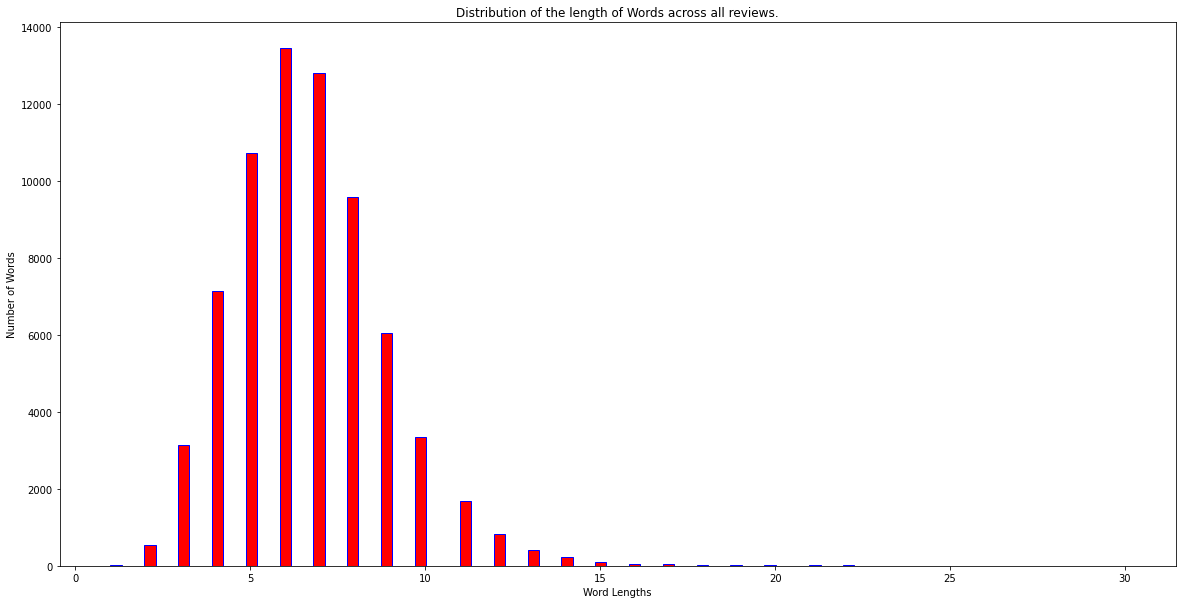

In [13]:
#We will check the distribution of stemmed word lengths across the whole review dataset to understand what is the length of the maximum number of words we will consider for the word to be relevant.
#In other words we will keep only those words which has a length less than that of a speicific length (we will obtain this specific length from the histogram).
from tqdm import tqdm
total_words = []

for review in tqdm(final_data['Text'].values):
    filtered_sentence=[]
    review = decontracted(review)
    review = removeNumbers(review)
    review = removeHtml(review)
    review = removeURL(review)
    review = removePunctuations(review)
    review = removePatterns(review)
    
    for cleaned_words in review.split():   
        if((cleaned_words not in custom_stopwords)):          
            stemed_word=(sno.stem(cleaned_words.lower()))
            total_words.append(stemed_word)

total_words = list(set(total_words)) #Get list of unique words.

#A list to hold the length of each words used in all the reviews used across the whole dataset.
dist = []
for i in tqdm(total_words):
    length = len(i)
    dist.append(length)

# matplotlib histogram to see the distribution of the length of words
plt.figure(figsize=(20,10))
plt.hist(dist, color = 'red', edgecolor = 'blue', bins =90)
plt.title('Distribution of the length of Words across all reviews.')
plt.xlabel('Word Lengths')
plt.ylabel('Number of Words')

### Conclusion from the above histogram:
We can see that most stemmed words present in the reviews has lengths between 4 and 10. Words which has length greater than 15 are very very very few as compared to other words. So we will discard these words from the reviews when we process them. It means we will consider only those words whose length is greater than 2 and less than 16.

In [14]:
# Combining all the above data cleaning methodologies as discussed above.

#Processing review Texts
preprocessed_reviews = [] #Store all the processed reviews
all_positive_words=[] #Store all the relevant words from Positive reviews
all_negative_words=[] #Store all the relevant words from Negative reviews
 
count=0     #Iterator to iterate through the list of reviews and check if a given review belongs to the positive or negative class
string=' '    
stemed_word=' '

for review in tqdm(final_data['Text'].values):
    filtered_sentence=[]
    review = decontracted(review)
    review = removeNumbers(review)
    review = removeHtml(review)
    review = removeURL(review)
    review = removePunctuations(review)
    review = removePatterns(review)
    
    for cleaned_words in review.split():   
        if((cleaned_words not in custom_stopwords) and (2<len(cleaned_words)<16)):
            stemed_word=(sno.stem(cleaned_words.lower()))                                   
            filtered_sentence.append(stemed_word)
            if (final_data['Score'].values)[count] == 'positive': 
                all_positive_words.append(stemed_word) #List of all the relevant words from Positive reviews
            if(final_data['Score'].values)[count] == 'negative':
                all_negative_words.append(stemed_word) #List of all the relevant words from Negative reviews
        else:
            continue
    review = " ".join(filtered_sentence) #Final string of cleaned words    
    preprocessed_reviews.append(review.strip()) #Data corpus contaning cleaned reviews from the whole dataset
    count+=1
    
#Save the list of positive words and negative words
import pickle
with open('all_positive_words.pkl', 'wb') as file:
    pickle.dump(all_positive_words, file)
    
with open('all_negative_words.pkl', 'wb') as file:
    pickle.dump(all_negative_words, file)
    
#Adding a column of CleanedText to the table final which stores the data_corpus after pre-processing the reviews 
final_data['CleanedText']=preprocessed_reviews 
    
print("The length of the data corpus is : {}".format(len(preprocessed_reviews)))

100%|██████████| 364171/364171 [14:09<00:00, 428.94it/s]


The length of the data corpus is : 364171


<h2><font color='red'>[3.2] Preprocessing Review Summary + Saving the Processed DB for future use.</font></h2>

In [15]:
## Similartly you can do preprocessing for summary summary also.
import warnings
warnings.filterwarnings("ignore")

preprocessed_summary = [] #Store all the processed summary
 
count=0     #Iterator to iterate through the list of summarys and check if a given summary belongs to the positive or negative class
string=' '    
stemed_word=' '

for summary in tqdm(final_data['Summary'].values):
    filtered_sentence=[]
    summary = decontracted(summary)
    summary = removeNumbers(summary)
    summary = removeHtml(summary)
    summary = removeURL(summary)
    summary = removePunctuations(summary)
    summary = removePatterns(summary)
    
    for cleaned_words in summary.split():
        if(2<len(cleaned_words)<16):
            stemed_word=(sno.stem(cleaned_words.lower()))
            filtered_sentence.append(stemed_word)
    summary = " ".join(filtered_sentence) #Final string of cleaned words    
    preprocessed_summary.append(summary.strip()) #Data corpus contaning cleaned summarys from the whole dataset
    count+=1
    
#Adding a column of CleanedSummary to the table final which stores the data_corpus after pre-processing the summarys 
final_data['CleanedSummary']=preprocessed_summary

#Combing the reviews with summary for each sentence
final_data['Combined_Reviews'] = final_data['CleanedText'].values + " " + final_data['CleanedSummary'].values 

#Store final table into an SQlLite table for future.

conn = sqlite3.connect('totally_processed_DB.sqlite')
sqlite_table = "Reviews"
final_data.to_sql(sqlite_table, conn, if_exists='replace')
conn.close

print("File is saved as 'totally_processed_DB.sqlite'")

100%|██████████| 364171/364171 [01:01<00:00, 5969.32it/s]


File is saved as 'totally_processed_DB.sqlite'


In [16]:
con = sqlite3.connect('totally_processed_DB.sqlite')
final_data1 = pd.read_sql_query(""" SELECT * FROM Reviews """, con) 
conn.close

<function Connection.close>

In [17]:
final_data1.head()

,level_0,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedSummary,Combined_Reviews
0,0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...,everi book educ,witti littl book make son laugh loud recit car...
1,1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...,love the book miss the hard cover version,grew read sendak book watch realli rosi movi i...
2,2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...,chicken soup with rice month,fun way children learn month year learn poem t...
3,3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read aloud nice rhythm well g...,good swingi rhythm for read aloud,great littl book read aloud nice rhythm well g...
4,4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...,great way learn the month,book poetri month year goe month cute littl po...


In [18]:
final_data1.columns

Index(['level_0', 'index', 'Id', 'ProductId', 'UserId', 'ProfileName',
       'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time',
       'Summary', 'Text', 'CleanedText', 'CleanedSummary', 'Combined_Reviews'],
      dtype='object')

## Analysis after performing preprocessing on TEXT

### Positive and Negative words in reviews

In [19]:
from collections import Counter
print("No. of positive words:",len(all_positive_words))
print("No. of negative words:",len(all_negative_words))
# print("Sample postive words",all_positive_words[:9])
# print("Sample negative words",all_negative_words[:9])
positive = Counter(all_positive_words)
print("\nMost Common postive words",positive.most_common(10))
negative = Counter(all_negative_words)
print("\nMost Common negative words",negative.most_common(10))

No. of positive words: 11791002
No. of negative words: 2426140

Most Common postive words [('not', 292389), ('like', 140360), ('tast', 130617), ('good', 113380), ('flavor', 110911), ('love', 107545), ('great', 104300), ('use', 103675), ('one', 97181), ('product', 91900)]

Most Common negative words [('not', 95184), ('tast', 35014), ('like', 32595), ('product', 28579), ('would', 23273), ('one', 20696), ('flavor', 19860), ('tri', 17740), ('use', 15271), ('good', 15116)]


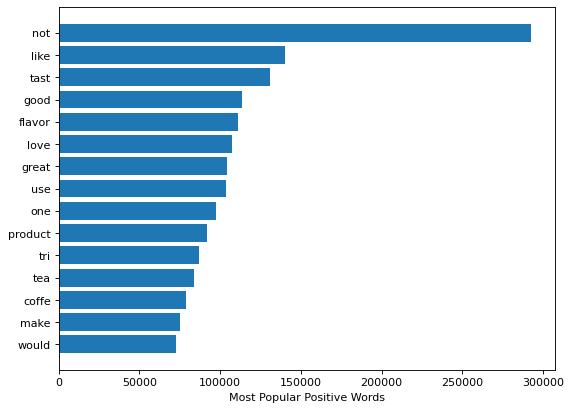

In [20]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
pos_words = positive.most_common(15)
pos_words.sort(key=lambda x: x[1], reverse=False) 
words=[]
times=[]
for w,t in pos_words:
    words.append(w)
    times.append(t)
plt.barh(range(len(words)),times)
plt.yticks(range(len(words)),words) 
plt.xlabel('Most Popular Positive Words')
plt.show()

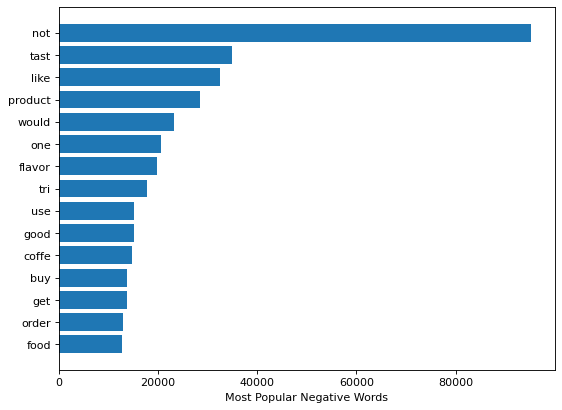

In [21]:
neg_words = negative.most_common(15)
neg_words.sort(key=lambda x: x[1], reverse=False) 
words=[]
times=[]
for w,t in neg_words:
    words.append(w)
    times.append(t)
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.barh(range(len(words)),times)
plt.yticks(range(len(words)),words) 
plt.xlabel('Most Popular Negative Words')
plt.show()

Observation:

* "tast" , "like" , "flavor", "good" and "one" are some of the most common words in both negative and positve reviews
* "good" and "great" are some of the most common words in positive reviews
* "would" and "coffe" are some of the most common words in negative reviews 
* tasty, good, etc are some of the words common in both <b>because there may be a not before it like "not tasty" , "not good"</b>

### Word Cloud of Whole Dataset

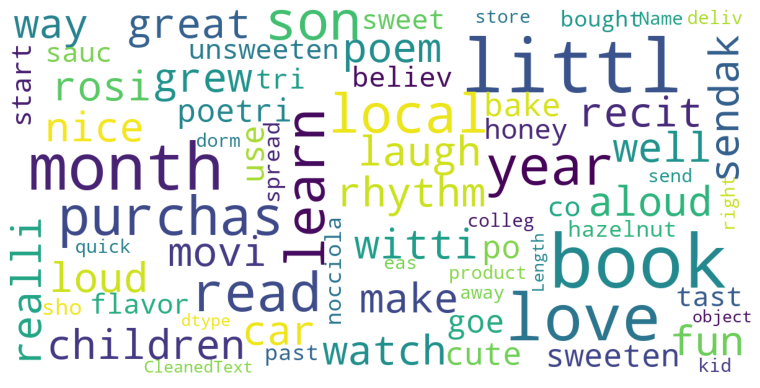

In [22]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

df2=final_data

plt.rcParams['figure.figsize']=(8.0,6.0)    #(6.0,4.0)
figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams['font.size']=12                #10 
plt.rcParams['savefig.dpi']=100             #72 
plt.rcParams['figure.subplot.bottom']=.1 


def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(8, 8))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()
    
show_wordcloud(df2['CleanedText'])
#df2.loc[df2['Score'] == 1]['CleanedText']

### Word Cloud of only Positive Reviews

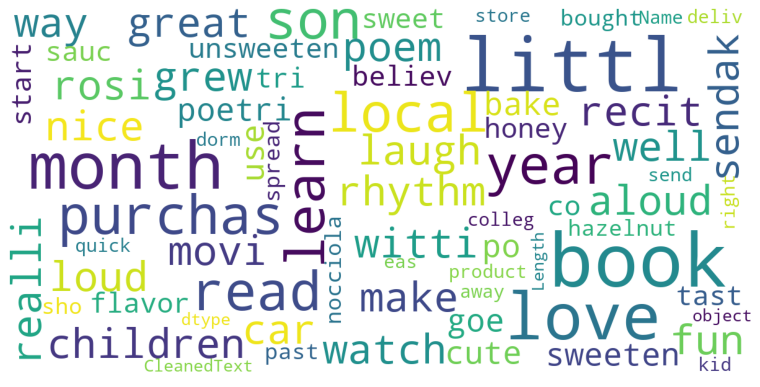

In [25]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

plt.rcParams['figure.figsize']=(8.0,6.0)    #(6.0,4.0)
figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams['font.size']=12                #10 
plt.rcParams['savefig.dpi']=100             #72 
plt.rcParams['figure.subplot.bottom']=.1 


def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(8, 8))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()
    
show_wordcloud(df2.loc[df2['Score'] == 'positive']['CleanedText'])

### Word Cloud of only Negative Reviews

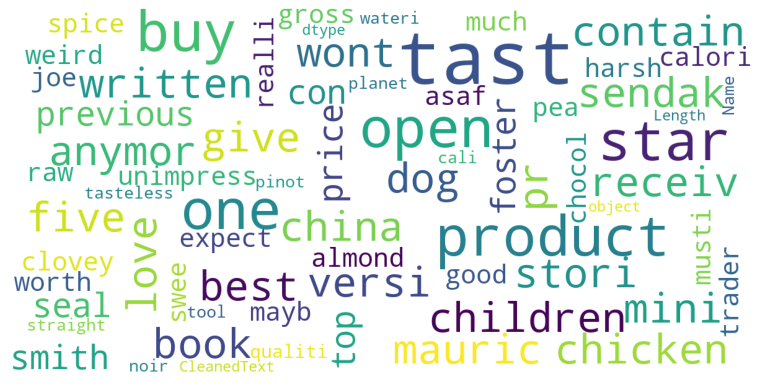

In [26]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

plt.rcParams['figure.figsize']=(8.0,6.0)    #(6.0,4.0)
figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams['font.size']=12                #10 
plt.rcParams['savefig.dpi']=100             #72 
plt.rcParams['figure.subplot.bottom']=.1 


def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(8, 8))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()
    
show_wordcloud(df2.loc[df2['Score'] == 'negative']['CleanedText'])